In [2]:
import re
import random
import pandas as pd
import hashlib

In [3]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]



mean = cards_to_age["age"].mean()
threshold = .005+(mean/2000)
shuffle_role = random.random()
print(f"{shuffle_role=:.6f}; {threshold=:.6f}")
if shuffle_role < threshold:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications 
priority_headers = [
    "Django", 
    "CCH Tax Forms Project",
    "Microsoft Purview"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.0718
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

shuffle_role=0.228667; threshold=0.022551


In [4]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index() # type: ignore
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Ansible,980.850599,13.254738,43.195277,74
"The Simulacra, Dick",13.945411,13.945411,13.945411,1
ODBC,334.831353,20.926960,60.057914,16
Network Terms,327.017121,21.801141,60.560643,15
"Everything is Tuberculosis, Green",552.761845,24.033124,63.205098,23
Exchange Online and Defender,1756.024815,26.606437,194.642308,66
SSH + SCP,869.981299,31.070761,120.781584,28
Terraform Codebox,881.083401,32.632719,106.811706,27
"The Mines of the Behemoth, Shea",1677.411388,34.232885,160.776788,49
Windows PATH Variable,891.187470,35.647499,164.440439,25


# Histogram

sum of ages: ~27880.82


<Axes: >

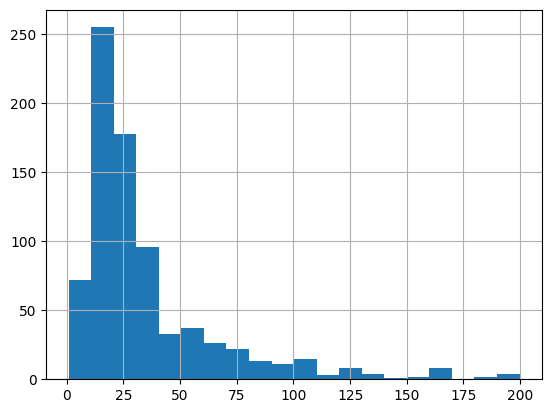

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~27880.82


<Axes: >

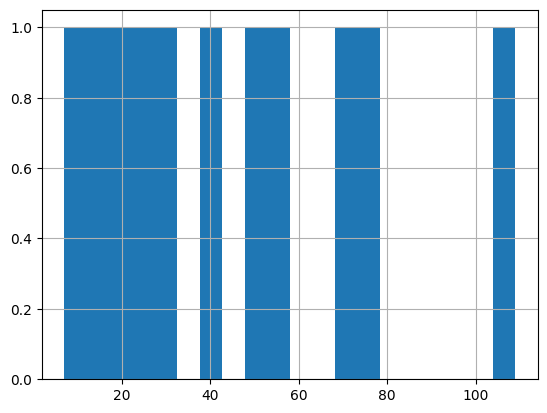

In [6]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Functions Core Tools']['age'].hist(bins=20)

# Completely Random Shuffle

In [7]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename="certcards2.txt", existing_cards=existing_cards)

# Age Sort

In [8]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [9]:
# n = 3
## m = existing_cards.shape[0]//100
# m = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [10]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 790
Total card age: 27880.82


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
267,Django,Requirements File (requirements.txt)\nLists Py...,013e69aef72c599aa98ad38e306aec0c,-199.722842,-63.708117,199.722842,573.373050,0.567055,9,0,0
535,Django,Gunicorn\nA common Python WSGI HTTP server use...,19d5aa44488acad61a5ffdb47ff78453,-64.403946,-63.708117,199.722842,573.373050,0.567055,9,3,0
537,Django,django-storages + azure-storage-blob\nLibrary ...,d9795055b98341d13a5b878a779a748e,-23.783609,-63.708117,199.722842,573.373050,0.567055,9,6,0
0,Active Directory and Azure Files,Discretionary ACL (DACL)\nDefines who is allow...,a1bf0647ab4195aec78120763462f822,-195.903496,-48.894978,195.903496,1369.059382,0.884697,28,0,0
1,Active Directory and Azure Files,Azure Entra ID Kerberos (AAD Kerberos)\nA newe...,386bc750335f13456684a817a6b13ce0,-101.527174,-48.894978,195.903496,1369.059382,0.884697,28,3,0
2,Active Directory and Azure Files,"Security Identifier (SID)\nA unique, immutable...",2f43c1b6e8a52dd6eb87a48edbe27f73,-73.567584,-48.894978,195.903496,1369.059382,0.884697,28,6,0
3,Active Directory and Azure Files,"NTLM Authentication\nOlder, fallback authentic...",772f8d525afeb02a4287cb433633c15c,-44.135660,-48.894978,195.903496,1369.059382,0.884697,28,9,0
546,Active Directory and Azure Files,userAccountControl Attribute\nA bitmask contro...,00853ecb2d1bcf4ecdebd9289b6c9e1a,-36.721542,-48.894978,195.903496,1369.059382,0.884697,28,12,0
5,Active Directory and Azure Files,Port 445 (SMB over TCP)\nRequired for SMB traf...,58bd1a1585626579ccf66e54188e2b25,-24.007259,-48.894978,195.903496,1369.059382,0.884697,28,15,0
6,Active Directory and Azure Files,Computer Account\nAn AD object that represents...,544d0d51a61eba5faa465832a1cb5412,-21.583635,-48.894978,195.903496,1369.059382,0.884697,28,18,0


## Age Max

In [11]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [12]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=existing_cards.shape[0]//100
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [13]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [14]:
existing_cards.head(10)['age'].sum()

np.float64(-785.3567466315978)

In [15]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
267,Django,Requirements File (requirements.txt)\nLists Py...,013e69aef72c599aa98ad38e306aec0c,-199.722842,-63.708117,199.722842,573.373050,0.567055,9,0,0
94,Python,XML Parsing with ElementTree\nUse xml.etree.El...,5e1ed8426d14aeb2c76d440c1c34ed35,-199.567629,-38.714922,199.567629,1935.746084,0.021643,50,0,0
0,Active Directory and Azure Files,Discretionary ACL (DACL)\nDefines who is allow...,a1bf0647ab4195aec78120763462f822,-195.903496,-48.894978,195.903496,1369.059382,0.884697,28,0,0
200,Exchange Online and Defender,You can integrate Defender for Office 365 with...,0f497c29704ee48dd3881866fc98d276,-194.642308,-26.606437,194.642308,1756.024815,0.750905,66,0,0
66,"Mexican Gothic, Moreno-Garcia",portiere (por-TYEHR)\nnoun\nA heavy curtain hu...,d5da010f1b1109c645a0f650a136111b,-188.174005,-41.696375,188.174005,917.320246,0.986942,22,0,0
74,Node.JS and React,State (React)\nA way to store data that change...,583960dd3b7acf10a28fe5f022b65809,-187.961065,-41.171047,187.961065,1276.302452,0.958049,31,0,0
42,Microsoft Purview,"As you work with Data Map and Unified Catalog,...",e37429937092d0eb362a3d9926a4db42,-169.404164,-46.152510,169.404164,1430.727800,0.498533,31,0,0
10,Node.js and Vite,Bundling\nThe process of combining many source...,a1c2dae683c349f89a0e85ace26524b9,-164.523799,-46.899335,164.523799,1360.080724,0.731820,29,0,0
155,Windows PATH Variable,Environment Variable Precedence\nOrder of eval...,fa0627e9753a4c1a855bf5f68e7fe4b5,-164.440439,-35.647499,164.440439,891.187470,0.620862,25,0,0
130,WinHex,HPA (Host Protected Area) & DCO (Device Config...,4b9ced335c770908c42c93aafb8be5b2,-163.750665,-36.446988,163.750665,728.939766,0.502083,20,0,0


In [16]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 35.292'